# Reinforcement Learning

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Alessio

In [2]:
# relaxation
T1 = 6e-3 
relax_rate = 0#1/T1 # relaxation
relax_op = np.sqrt(relax_rate) * q.tensor(q.sigmap(), q.qeye(2))

# dephasing
T2 = 35e-6
deph_rate = 0#(-1/T1+2/T2)/2 # dephasing
deph_op = np.sqrt(0.5 * deph_rate) * q.tensor(q.sigmaz(), q.qeye(2))

rabi_freq = 0.5e6
proj_NV0 = q.ket2dm(q.basis(2,0))
proj_NV1 = q.ket2dm(q.basis(2,1))

def H_Suter():   
    H = (-0.158e6) * q.tensor(proj_NV0, 0.5*q.sigmaz()) + (-0.158e6 + 0.152e6) * q.tensor(proj_NV1, 0.5*q.sigmaz()) + (-0.110e6) * q.tensor(proj_NV1, 0.5*q.sigmax()) 
    return 2 * np.pi * H

def H_MW(phi):
    H = rabi_freq * np.cos(phi)/2 * q.tensor(q.sigmax(), q.qeye(2)) + rabi_freq * np.sin(phi)/2 * q.tensor(q.sigmay(), q.qeye(2))
    return 2 * np.pi * H

def U_free_super(free_time):
    H = H_Suter()
    c_ops = [relax_op, deph_op]
    L = q.liouvillian(H, c_ops)
    return (free_time*L).expm()

def U_pulse_super(pulse_time, phi):
    H = H_Suter() + H_MW(phi)
    c_ops = [relax_op, deph_op]
    L = q.liouvillian(H, c_ops)
    return (pulse_time*L).expm()
    # return scipy.linalg.expm(pulse_time*L.full())

def calc_superop(pulse_seq, num_pulses):
    U = 1
    for i in range(num_pulses):
        free_time, pulse_time, phi = pulse_seq[i], pulse_seq[i+num_pulses], pulse_seq[i+2*num_pulses]
        U = U_pulse_super(pulse_time, phi) * U_free_super(free_time) * U
    if len(pulse_seq) != 3*num_pulses:
        U = U_free_super(pulse_seq[-1]) * U
    return U

In [3]:
num_pulses = 3
pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2, 0.89e-6] # Suter Hadamard
superop = calc_superop(pulse_seq, num_pulses)

target_hada = q.tensor(q.qeye(2), q.gates.hadamard_transform())
target_superop = q.tensor(target_hada.conj(), target_hada)
target_superop.dims = [target_hada.dims, target_hada.dims]

calc_fidelity(superop, target_superop)

np.float64(0.9437899973536489)

In [4]:
num_pulses = 3
pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2, 0.63e-6] # Suter CNOT
superop = calc_superop(pulse_seq, num_pulses)

target_cnot = q.tensor(proj_NV0, q.qeye(2))  -1j * q.tensor(proj_NV1, q.sigmax())
target_superop = q.tensor(target_cnot.conj(), target_cnot)
target_superop.dims = [target_cnot.dims, target_cnot.dims]

calc_fidelity(superop, target_superop)

np.float64(0.9797014459277309)

## Lindblad Environment 

In [5]:
import gymnasium as gym

class Parametric_env(gym.Env):
    MAX_STEPS = 2
    INFIDELITY_THRESHOLD = 0.1

    def __init__(self, target_superop):
        self.target_superop = target_superop

        # action and observation spaces
        self.action_space = gym.spaces.Box(low=-1, high= 1, shape=(3,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(512,), dtype=np.float64)

        self.reset()

    def _get_obs(self):
        A = self.superop.full()
        real = A.flatten().real.tolist()
        imag = A.flatten().imag.tolist()
        return np.array(real + imag)

    def reset(self,seed=None, options=None):
        super().reset(seed=seed)
        self.superop = U_free_super(0)
        self.fidelity = calc_fidelity(self.superop, self.target_superop)
        self.count = 0
        self.reward = 0
        self.done = False
        self.duration = 0
        self.observation = self._get_obs()
        self.info = {}

        return self.observation,{}

    def step(self, action):
        if self.done:
            print("EPISODE DONE!!!")
        elif (self.count == self.MAX_STEPS):
            self.done = True
        else:
            assert self.action_space.contains(action)
            self.count += 1
            
        pulse_seq = [
            2.0e-6*np.abs(action[0]), #+ np.abs(0.1),
            2.0e-6*np.abs(action[1]), #+ np.abs(0.1),
            2*np.pi*action[2]
        ]
        superop_layer =  calc_superop(pulse_seq, 1)
        
        self.superop = superop_layer @ self.superop
        self.fidelity = calc_fidelity(self.superop, self.target_superop)
        self.info = {"Fidelity": self.fidelity}

        if 1-self.fidelity < self.INFIDELITY_THRESHOLD:
            self.done = True

        if self.done:
            self.reward = -np.log(1-self.fidelity)
        else:
            self.reward = 0

        self.observation = self._get_obs()

        return (self.observation, self.reward, self.done,self.done, self.info)

In [7]:
target_hada = q.tensor(q.qeye(2), q.gates.hadamard_transform())
target_superop = q.tensor(target_hada.conj(), target_hada)
target_superop.dims = [target_hada.dims, target_hada.dims]

param_env = Parametric_env(target_superop=target_superop) 
param_env.step( [0.74/2, 0.23/2, 3/4] )
param_env.step( [0.22/2, 1.26/2, 3/4] )
param_env.step([0.43/2, 1.50/2, 1/4] )
param_env.step( [0.89/2, 0, 0] )
param_env.fidelity

EPISODE DONE!!!


np.float64(0.9437899973536489)

In [9]:
from stable_baselines3.common.env_checker import check_env

param_env = Parametric_env(target_superop = U_free_super(0))
check_env(param_env, warn=True)

In [10]:
from stable_baselines3 import PPO

target_hada = q.tensor(q.qeye(2), q.gates.hadamard_transform())
target_superop = q.tensor(target_hada.conj(), target_hada)
target_superop.dims = [target_hada.dims, target_hada.dims]

param_env = Parametric_env(target_superop=target_superop)
model = PPO("MlpPolicy", param_env, learning_rate=0.00005,
            gamma=0.99,n_steps=1024,batch_size=256,
            clip_range=0.3, n_epochs=10,ent_coef=0.003, 
            verbose = 1,tensorboard_log="./ppo_cartpole_tensorboard/diss3/").learn(10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_cartpole_tensorboard/diss3/PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | 0.14     |
| time/              |          |
|    fps             | 697      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 1024     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3            |
|    ep_rew_mean          | 0.166        |
| time/                   |              |
|    fps                  | 665          |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 6.786431e-05 |
|    clip_fraction        | 0            |


## Cluster Expansion Environment

In [16]:
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]

directory = os.getcwd()
filename = os.path.join('baths', 'dominik_bath')
bath_configs_nested = load_spin_baths(filename, directory)
bath_configs = [item for sublist in bath_configs_nested for item in sublist]

# Bell (Hadamard and CNOT)
init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

kwargs = dict(verbose=False, env_approx_level="no_bath", bath_configs=bath_configs, suter_method=True, target=bell_state)
env = Environment2(register_config, **kwargs)

In [3]:
env.reset()
env.step([2*0-1, 2*0.99813568/(2*np.pi)-1, 2*0.69459264/(2*np.pi)-1 ], instant_pulses=True)
env.step([ 2*4.06620465-1, 2*3.57557112/(2*np.pi)-1, 2*1.97327426/(2*np.pi)-1], instant_pulses=True)
env.step([2*1.57022726-1, 2*1.68300382/(2*np.pi)-1, 2*0.50816523/(2*np.pi)-1], instant_pulses=True)
env.step([2*1.50788214-1, 2*0-1, 2*0-1 ], instant_pulses=True)
env.fidelity

np.float64(0.743965071416384)

In [18]:
from stable_baselines3.common.env_checker import check_env
check_env(env, warn=True)

In [19]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, learning_rate=0.00005,
            gamma=0.99,n_steps=1024,batch_size=256,
            clip_range=0.3, n_epochs=10,ent_coef=0.003, 
            verbose = 1,tensorboard_log="./ppo_cartpole_tensorboard/diss3/").learn(30000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_cartpole_tensorboard/diss3/PPO_22
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 4        |
|    ep_rew_mean     | 0.345    |
| time/              |          |
|    fps             | 334      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 1024     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 4             |
|    ep_rew_mean          | 0.321         |
| time/                   |               |
|    fps                  | 332           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 0.00010418461 |
|    clip_fraction        | 0  

## Open Quantum Systems

A good source is Hashim 2024 (https://arxiv.org/abs/2408.12064)

In [4]:
op = q.sprepost(q.sigmax(), q.sigmaz())

In [8]:
q.to_kraus(op)

[]

In [9]:
q.to_choi(op)

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=Dense, isherm=False, superrep='choi'
Qobj data =
[[ 0.  0.  0.  0.]
 [ 1.  0.  0. -1.]
 [ 1.  0.  0. -1.]
 [ 0.  0.  0.  0.]]

In [15]:
op = q.kraus_to_super([q.sigmay()])
q.to_kraus(op)

[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
 Qobj data =
 [[ 0.  1.]
  [-1.  0.]]]

In [14]:
q.sprepost(q.sigmay(), q.sigmay())

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', dtype=CSR, isherm=True
Qobj data =
[[ 0.  0.  0.  1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]]

In [12]:
# krauss_list

q.tensor(q.sigmax(), q.sigmaz())

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]]

In [21]:
dm = q.Qobj([[0.8,0.4], [0.4,0.2]]) # q.ket2dm(q.basis(2,0))

dm1 = q.vector_to_operator( q.sprepost(q.sigmax(), q.sigmaz()) * q.operator_to_vector(dm) )
dm2 = q.sigmax() * dm * q.sigmaz()
dm1==dm2

True

In [203]:
from itertools import product

def get_pauli_basis(num_qubits):
    """ Calculates the basis of the Hilbert space formed by the Pauli matrices (I, X, Y, Z). """

    pauli_basis = []
    
    pauli_ops = [q.qeye(2), q.sigmax(), q.sigmay(), q.sigmaz()]
    for pauli_list in product(pauli_ops, repeat=num_qubits):
        pauli_basis.append( q.tensor(pauli_list) )

    return pauli_basis

def get_matrix_unit_basis(num_qubits):  
    """ Calculates the basis of the Hilbert space formed by the unit matrices. """
    
    matrix_unit_basis = []
    
    dim = 2**num_qubits
    for i, j in product(range(dim), repeat=2):
        element = q.basis(dim, i) * q.basis(dim, j).dag()
        element.dims = [[2]*num_qubits, [2]*num_qubits]
        matrix_unit_basis.append(element)
        
    return matrix_unit_basis
    
# ----------------------------------------

def calc_unit_transfer_matrix_old(krauss_list):
    """ Calculates the transfer matrix in the matrix unit basis according to Eq. (73) from the Kraus representation of a quantum map.
    Notes: Apply q.operator_to_vector() for the density matrix. q.kraus_to_super() """
    
    transition_matrix = 0
    
    for krauss_op in krauss_list:
        transition_matrix += q.tensor(krauss_op.conj(), krauss_op)
    transition_matrix.dims = [krauss_op.dims, krauss_op.dims]
    
    return transition_matrix

def calc_transfer_matrix(krauss_list, basis):
    """ Calculates the transfer matrix from the Kraus representation of a quantum map. """

    dim = krauss_list[0].shape[0]
    num_qubits = int(np.log2(dim))
    
    transfer_matrix = np.zeros((dim**2, dim**2), dtype=complex)
    
    for krauss_op in krauss_list:
        for i, op_i in enumerate(basis):
            for j, op_j in enumerate(basis):
                transfer_matrix[i, j] = (op_i * krauss_op * op_j * krauss_op.dag() ).tr()

    dims = [ [[2]*num_qubits, [2]*num_qubits], [[2]*num_qubits, [2]*num_qubits] ]     
    return q.Qobj(transfer_matrix, dims=dims)


def calc_pauli_transfer_matrix(krauss_list):
    """ Calculates the Pauli transfer matrix (PTM) according to Eq.(75) from the Kraus representation of a quantum map. """

    dim = krauss_list[0].shape[0]
    num_qubits = int(np.log2(dim))
    pauli_basis = get_pauli_basis(num_qubits)
    
    return calc_transfer_matrix(krauss_list, pauli_basis)

def calc_unit_transfer_matrix(krauss_list):
    """ Calculates the transfer matrix in the matrix unit basis according to Eq. (73) from the Kraus representation of a quantum map.
    Notes: Apply q.operator_to_vector() for the density matrix. q.kraus_to_super() """

    dim = krauss_list[0].shape[0]
    num_qubits = int(np.log2(dim))
    unit_basis = get_pauli_basis(num_qubits)

    return calc_transfer_matrix(krauss_list, unit_basis)
    

def calc_chi_matrix(krauss_list):
    """ Calculates the Chi process matrix according to Eq. (88) from the Kraus representation of a quantum map. q.to_chi() or q.kraus_to_choi() and q._choi_to_chi() """
    
    krauss_op = krauss_list[0]
    num_qubits = len(krauss_op.dims[0])
    shape = krauss_op.shape[0]**2, krauss_op.shape[1]**2

    chi_matrix = np.zeros((4**num_qubits, 4**num_qubits), dtype=complex)
    pauli_basis = get_pauli_basis(num_qubits)
    
    for krauss_op in krauss_list:
        for j, pauli_j in enumerate(pauli_basis):
            for k, pauli_k in enumerate(pauli_basis):
                chi_matrix[j, k] = sum( [(pauli_m * pauli_j * krauss_op * pauli_m * krauss_op.dag() * pauli_k ).tr() for pauli_m in pauli_basis] )
          
    return q.Qobj(chi_matrix, dims=dims) / (2**num_qubits)**3

def calc_choi_matrix():
    """ Calculates the Chi process matrix according to Eq. (112) from the Kraus representation of a quantum map. q.kraus_to_choi() """

    krauss_op = krauss_list[0]
    num_qubits = len(krauss_op.dims[0])
    shape = krauss_op.shape[0]**2, krauss_op.shape[1]**2

    choi_matrix = np.zeros((4**num_qubits, 4**num_qubits), dtype=complex)

    for krauss_op in krauss_list:
        krauss_vec = q.operator_to_matrix(krauss_op)
        choi_matrix += np.outer(krauss_vec, krauss_vec.conj())
    
    return q.Qobj(choi_matrix, dims=dims)

# ----------------------------

def calc_pauli_state(dm):
    """ Calculates the vectorized density matrix expressed in the Pauli basis. """

    
    num_qubits = len(dm.dims[0])
    pauli_state = np.zeros((dm.shape[0]**2, 1), dtype='complex')

    pauli_basis = get_pauli_basis(num_qubits)

    for i, pauli in enumerate(pauli_basis):
        pauli_state[i] = (pauli * dm).tr() / 2**num_qubits
    return pauli_state

In [204]:
krauss_list = [q.tensor(q.qeye(2), q.gates.hadamard_transform())]

In [ ]:
def calc_process_fidelity(U, U_target):
    """ Calculates the process fidelity in Eq. (237). """
    
    dim = U.shape[0]
    PTM_U = calc_pauli_transfer_matrix([U])
    PTM_U_target = calc_pauli_transfer_matrix([U_target])
    return (PTM_U * PTM_U_target.inv()).tr() / dim**2

# Martinez2020 (10.1109/ACCESS.2020.3025619): amplitude-phase damping (APD) superoperator channel

# gamma = 1-np.exp(-t/T1) # amplitude damping channel, eq.(8)
# lam = 1-np.exp(t/T1-2*t/T2)  # dephasing channel, eq.(13)

# eq. (15)
# E0 = ((1+np.sqrt(1-gamma-(1-gamma)*lam))/2)*Id+((1-np.sqrt(1-gamma-(1-gamma)*lam))/2)*Z # eq.()
# E1 = (np.sqrt(gamma)/2)*X+ 1j*(np.sqrt(gamma)/2)*Y
# E2 = (np.sqrt((1-gamma)*lam)/2)*Id-(np.sqrt((1-gamma)*lam)/2)*Z

# Schlimgen2022 (10.1103/PhysRevResearch.4.023216): eq.(3)

## Benchmark Environment Step Function 

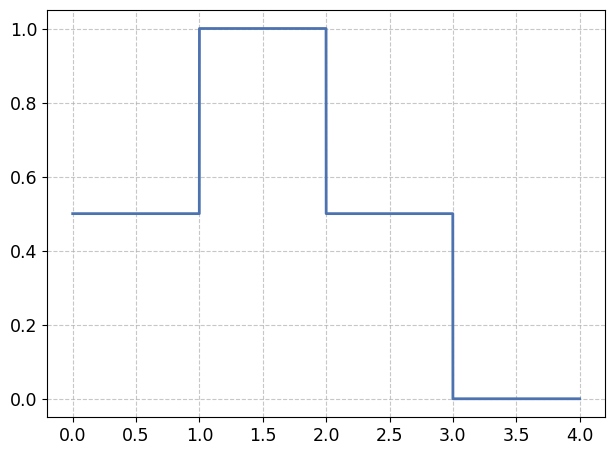

In [2]:
# without step function

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(instant_pulses = True, verbose = False, target=q.Qobj(np.array([[0.5, 0.5j], [-0.5j, 0.5]])))

env = Environment(register_config, [], **kwargs)
pulse_seq = [1e-6, 1e-6, 1e-6, 1e-6, np.pi/2, np.pi/2, np.pi/2, 0, 0, 0]
t_list = list(np.arange(0, 4.1e-6, 0.1e-6))
t_list.extend([1e-6-1e-9, 2e-6-1e-9, 3e-6-1e-9])
t_list = np.array(sorted(t_list))
fidelities = env.get_values(pulse_seq, 'fidelity', t_list=t_list)

fig, ax = plt.subplots()
ax.plot(t_list*1e6, fidelities)
plt.show()

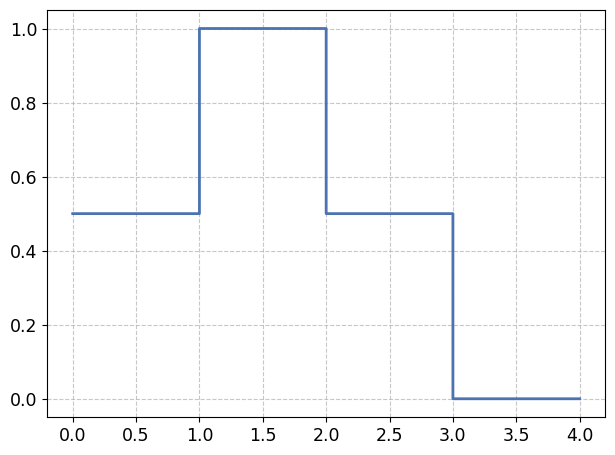

In [3]:
# with step function

register_config = [('NV0', (0, 0, 0), 0, {})]
kwargs = dict(instant_pulses = True, verbose = False, target=q.Qobj(np.array([[0.5, 0.5j], [-0.5j, 0.5]])), skip_first_evo=True)

env = Environment(register_config, [], **kwargs)
fidelities = []
fidelities.append(env.fidelity)
for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)
env.step([0, 1/4, 0])
fidelities.append(env.fidelity)

for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)
env.step([0, 1/4, 0])
fidelities.append(env.fidelity)

for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)
env.step([0, 1/4, 0])
fidelities.append(env.fidelity)

for _ in range(10):
    env.step([0.1e-6, 0, 0])
    fidelities.append(env.fidelity)

t_list = list(np.arange(0, 4.1e-6, 0.1e-6))
t_list.extend([1e-6, 2e-6, 3e-6])
t_list = np.array(sorted(t_list))

fig, ax = plt.subplots()
ax.plot(t_list*1e6, fidelities)
plt.show()